In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.hatch import HatchPatternBase, _hatch_types
import matplotlib.patches as patches
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.cm as cm

# How to draw limestones in Python

Matplotlib offers tantalizing hatching options that will sadly leave most geologists a little frustrated. It's a bit like pattern fills in Excel - so much potential until you actually try and use it to make satisfying lithology logs. 

Unlike Excel however, you can customize Matplotlib's hatch function to your heart's content. I show an example here of how to create a standard limestone hatch, but the methodology can be generalized to created pretty much any lithology pattern you want.

## A brief introduction to using hatches in Matplotlib

Hatches can be used with any Matplotlib object that takes `hatch` as an argument: most Matplotlib polygons including `bar`, `fill_between`, `fill_betweenx`, `contourf`, and children of `Polygon`. The one of interest to us here is `fill_between`. Ten hatches come built-in and are called by specific flags in the string provided to the `hatch` argument:

| Flag | Description       |
|:----:|:------------------|
| /    | diagonal hatching |
| \    | back diagonal     |
| \|   | vertical          |
| \-   | horizontal        |
| \+   | crossed           |
| x    | crossed diagonal  |
| o    | small circle      |
| O    | large circle      |
| .    | dots              |
| \*   | stars             |

Multiple flags can be used to combine the various hatches, and repeating an individual flag will increase that hatch's density. The background color of the hatch is controlled by the `facecolor` / `fc` argument and its line color is controlled by the `edgecolor` / `ec` argument. Unfortunately the linewidth of the hatch can only be controlled globally via the use of rc parameters.

## Example hatch usage in Matplotlib

Below are some examples of using the built-in hatches in Matplotlib.

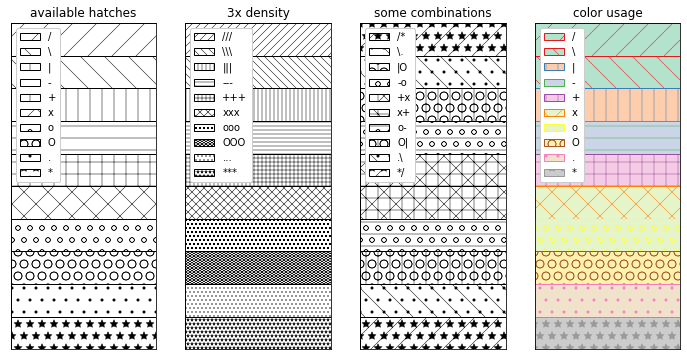

In [2]:
# string with available built-in hatches
hatches = r"/\|-+xoO.*"

# set hatch linewidth
rcParams['hatch.linewidth'] = 0.5

# setup some color maps
edge_cmap = cm.get_cmap('Set1')
face_cmap = cm.get_cmap('Pastel2')
norm = colors.Normalize(vmin=0, vmax=len(hatches))


fig, axs = plt.subplots(1, 4, figsize=(12,6))

for i, h in enumerate(hatches):
    x, y1, y2 = [0,1], [i]*2, [i+1]*2
    # plot all possible hatches
    axs[0].fill_between(x, y1, y2, 
                    hatch=h,
                    fc='None',
                    ec='k',
                    label=h)
    
    # plot all possible hatches in double density
    axs[1].fill_between(x, y1, y2, 
                    hatch=h*3,
                    fc='None',
                    ec='k',
                    label=h*3)
    
    # plot some hatch combinations
    axs[2].fill_between(x, y1, y2, 
                    hatch=h+hatches[-(i+1)],
                    fc='None',
                    ec='k',
                    label=h+hatches[-(i+1)])
    
    # change colors
    axs[3].fill_between(x, y1, y2, 
                    hatch=h,
                    fc=face_cmap(norm(i)),
                    ec=edge_cmap(norm(i)),
                    label=h)
        
titles = ['available hatches', '3x density', 'some combinations', 'color usage']
for i, ax in enumerate(axs):
    ax.title.set_text(titles[i])
    ax.set_xlim(0, 1)
    ax.set_ylim(len(hatches), 0)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(loc='upper left', framealpha=1)

plt.show()

## Making our own custom hatch pattern for limstones

### Hatch pattern

A hatch pattern is nothing more than a path. It must however fit within a unit square and will be repeated in the $x$ and $y$ directions to fill the entire hatched area. Care should therefore be taken to ensure the sides of the pattern match up as needed. Below is such a path for a traditional limestone brick pattern. Care has been taken to ensure that none of the lines fall along the edge of the unit square as this can lead to unsatisfactory looking patterns.

The `path_vertices` array contains the coordinates of the vertices that make up the path of our desired pattern. This path will ultimately be used by Matplotlib to create a `Path` object that it will use as the hatch pattern. A `Path` object requires a $[n\text{ x }2]$ array of vertices and a $[n\text{ x }1]$ array of codes. The array of codes tells the renderer what to do with the "pen" between vertices and can take the values `MOVETO`, `LINETO`, `CURVE3`, or `CURVE4` (the latter 2 being used to define quadratic and cubic Bézier curves respectively). A final value `CLOSEPOLY` exists to close a polygon.

> Bézier curves can be used in hatch patterns. In fact, Matplotlib uses them for the circle and dot hatches.

In our example, the path is made up of 5 segments, with the pen moving at the start of each segment. The `LimestoneHatch` class we will define below automatically handles the codes for this (as well as for an arbitrary number or segments). Ultimatley, any path can be used to create a hatch pattern, though the class that creates the required path vertice and code arrays would need to be udpated accordingly.  

In [3]:
path_vertices = np.array([[0.25,0.25],  # MOVETO
                          [0.25,0.75],  # LINETO
            
                          [0,0.25],     # MOVETO
                          [1,0.25],     # LINETO
                             
                          [0,0.75],     # MOVETO
                          [1,0.75],     # LINETO
                             
                          [0.75,0.75],  # MOVETO
                          [0.75,1],     # LINETO
                             
                          [0.75,0.],    # MOVETO
                          [0.75,0.25]]) # LINETO

Let's take a look at what the path looks like (this step is for illustration purposes only and it not required):


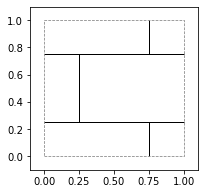

In [5]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(-0.1,1.1)
ax.set_ylim(-0.1,1.1)

# unit square bounding box
ax.plot([0,1,1,0,0], [0,0,1,1,0], c='0.5', ls='--', lw=0.75)

# Create a Path object with path_vertices and an appropriate list of codes
path = Path(path_vertices, 
            codes=[Path.MOVETO, Path.LINETO] * int(len(path_vertices)/2))

# Create a Patch from this path and add it to the plot
patch = patches.PathPatch(path)
ax.add_patch(patch)

plt.show()

### Hatch Class

We now create a custom class `LimestoneHatch` that will prepare a path that Matplotlib will use for the hatch. This class will be instantiated (along with the other hatch pattern classes) by Matplotlib's bakcends when it renders the plot.

The `__init__()` instantiation method counts the number of occurences of our limestone flag in the hatch string (*"L"* in our case) and determines the total number of vertices taking in to account how many times the base pattern will be repeated over the unit square. The `density` argument is handled by Matplotlib, though you can modify it here to decrease (or increase) the minimum density of our limestone hatch.

1. The unit square is notionally divided into $n$ equal area subsquares so that there are `num_lines` subsquares in each row and column, *i.e.*, $n=num\_lines^2$. 

2. The total number of vertices (and codes) is therefore the number of vertices in the path times the total number of times the path is repeated over the unit square.

The `set_vertices_and_codes()` method then provides Matplotlib with all the necessary vertices and corresponding codes to correctly render all the repetitions of our path within the unit square. This path can then be repeated with the desired density throughout the area to be filled with the hatch. This is achieved as follows:

1. Line 20: the `steps` array lists all the possible $x$ and $y$ starting coordinates for these subsquares. _E.g._, if $num\_lines=2$, $steps=[0, 0.5]$; or if $num\_lines=4$, $steps=[0,0.25,0.5,0.75]$.

2. Line 21: we use NumPy's `meshgrid`, `transpose` and `reshape` methods to create a $(n\text{ x }2)$ array `offsets` of all the $(x_i,y_i)$ starting coordinates for the subsquares. This array is then repeated (using NumPy's repeat method) by the number of vertices in the path such that the final array has a $(number\text{ }of\text{ }vertices * n\text{ x }2)$ shape. E.g., in the case $num\_lines=2$ and with our path with 10 vertices:

3. Line 26: `path_vertices` is then scaled down to the size of the subsquares and tiled $n$ times (see NumPy documentation for the difference between `repeat` and `tile`). By adding `offsets` we can translate the tiled slices to their correct position within the larger unit square. The result is used to update the slice of `vertices` that are supplied by Matplotlib to the `set_vertices_and_codes` method.

4. Lines 30-31: finally, we update the slices of `codes` that are supplied by matplotlib to the `set_vertices_and_codes` method. We simply set all even numbered rows to `Path.MOVETO' and odd ones to `Path.LINETO`. The slice of `codes` is already the correct shape so we don't need to worry about that.


> **Important note:**
>
> After Matplotlib has instantiated a hatch class object, it supplies its `set_vertices_and_codes` method with a slice of the wider `vertices` and `codes` NumPy arrays Matplotlib is assembling that contain all the hatch types that will make up the final hatch.
>
> As a NumPy slice is a view of the array and not copy, care should be taken to update the content of the slice and not replace the slice with a whole new array.

In [5]:
# reduce linewidth of hatch patterns
rcParams['hatch.linewidth'] = 0.25


class LimestoneHatch(HatchPatternBase):
    
    def __init__(self, hatch, density):

        # number of times the path will be repeated in one direction
        # within the unit square
        self.num_lines = int((hatch.count('l') + hatch.count('L')) * density)   
        
        # total number of vertices for the path once it has been
        # repeated the appropriate number of times within the unit square
        self.num_vertices = (self.num_lines ** 2 * len(path_vertices))


    def set_vertices_and_codes(self, vertices, codes):
        
        steps = np.linspace(0, 1, self.num_lines, endpoint=False)
        offsets = np.array(np.meshgrid(steps,steps)).transpose([1,2,0]) \
                        .reshape((self.num_lines**2, 2)) \
                        .repeat(len(path_vertices), axis=0)
        
        # update values in slice of vertices array
        vertices[:] = np.tile(path_vertices / self.num_lines, 
                              (self.num_lines**2, 1)) + offsets
        
        # update values in slice of codes array
        # all even rows are set to MOVETO & all odd rows to LINETO
        codes[0::2] = Path.MOVETO
        codes[1::2] = Path.LINETO

We must add our new custom hatch class to `_hatch_types` so it is included in the list of hatches that Matplotlib will use:

In [6]:
_hatch_types.append(LimestoneHatch)

Our custom limestone hatch pattern is now ready to use!

### Usage example

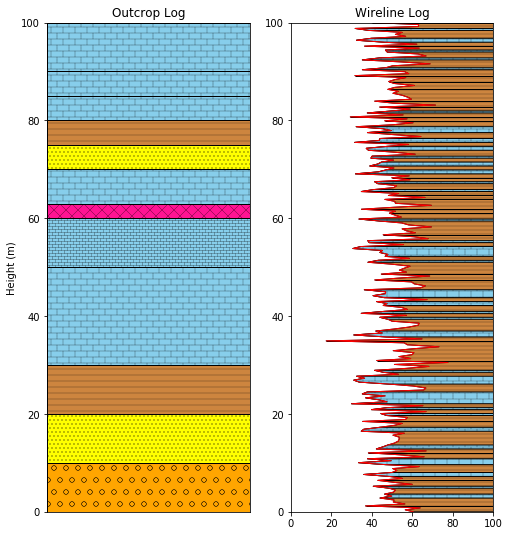

In [8]:
# list of beds to draw
#          base   top   lithology
beds =   [[0,     10,   'conglomerate'],
          [10,    20,   'sandstone'],
          [20,    30,   'shale'],
          [30,    50,   'limestone'],
          [50,    60,   'limestone2'],
          [60,    63,   'evaporite'],
          [63,    70,   'limestone'],
          [70,    75,   'sandstone'],
          [75,    80,   'shale'],
          [80,    85,   'limestone'],
          [85,    90,   'limestone'],
          [90,   100,   'limestone'],
          ]

# lithology style dictionary
lithologies = {'conglomerate': ['o',  'orange',   'k'],
               'sandstone':    ['...', 'yellow',   'k'],
               'shale':        ['--', 'peru',     'k'],
               'limestone':    ['l',  'skyblue',  'k'],
               'limestone2':   ['ll', 'skyblue',  'k'],
               'evaporite':    ['xx', 'deeppink', 'k'],}

GR = np.random.normal(loc=50, scale=10, size=250)

fig, ax = plt.subplots(1, 2, figsize=(8,9))
ax[0].set_xlim(0,1)
ax[0].set_xticks([])
ax[0].set_ylim(0, 100)
ax[0].title.set_text('Outcrop Log')

ax[0].set_ylabel('Height (m)')

for b in beds:
    l = lithologies[b[2]]
    ax[0].fill_between([0, 1], [b[0]]*2, [b[1]]*2, hatch=l[0], fc=l[1], ec=l[2], label=b[2])
    
ax[1].fill_betweenx(np.linspace(0, 100, 250), GR, 100, fc='peru', ec='k', hatch='---')
ax[1].fill_betweenx(np.linspace(0, 100, 250), GR, 100, where=GR<50, fc='skyblue', ec='k', hatch='l')
ax[1].plot(GR, np.linspace(0, 100, 250), c='r', lw=1)
ax[1].set_xlim(0,100)
ax[1].set_ylim(0,100)
ax[1].title.set_text('Wireline Log')

plt.savefig('limestone.pdf')
plt.show()